<a href="https://colab.research.google.com/github/DanielRajChristeen/Custom-trained-YOLOv11-Model/blob/main/Custom_YOLOv11_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom YOLO Object Detection**
In this project, we developed a custom YOLOv11 model specifically designed to detect and classify road signs. YOLOv11 is a state-of-the-art object detection architecture that balances speed and accuracy, making it ideal for real-time applications.

We trained the model on a curated road sign dataset, containing multiple classes such as Traffic Light, Stop, Speed Limit, and Crosswalk. The dataset was converted from Pascal VOC annotations to the YOLO format, split into training and validation sets, and fed into YOLOv11 for fine-tuning.

The model is capable of accurately detecting multiple road sign classes in images, generating bounding boxes with class predictions, and providing performance metrics like precision, recall, and mAP. This makes it suitable for applications in autonomous driving, traffic monitoring, and driver-assistance systems.

By training a custom model, we ensure it is tailored to our dataset, achieving better detection accuracy than generic pre-trained models. The project also demonstrates how to handle annotation conversion, dataset preparation, and model evaluation in a practical workflow.

## **Step 0 — Install Dependencies**
This snippet sets up the core environment for your YOLOv11 object detection project. Before any model training or inference happens, you must ensure the right packages are installed.

The libraries,
* **ultralytics** – Provides easy-to-use YOLOv11 tools for training, validating, and running object detection models.

* **opencv-python** – Enables image and video processing operations for computer vision tasks.

* **kaggle** – Lets you download and manage datasets directly from Kaggle using their API.

In [ ]:
# Step 0: Install dependencies
!pip install ultralytics opencv-python kaggle --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00


## **Step 1 -  Upload Kaggle API token**
Opens a file picker in Colab to upload your kaggle.json API token so you can access Kaggle datasets.

How to get kaggle.json:

1. Go to https://www.kaggle.com
 and log in.

2. Click your profile photo → Account.

3. Scroll to API section → click Create New API Token.

4. This downloads a kaggle.json file — keep it safe, and upload it in this step.

In [ ]:
# Step 1: Upload Kaggle API token
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielrajchristeen","key":"fea98c9c0a1e7bf27dbe5b6b113e7a02"}'}

## **Step 2 - Setting Up Kaggle API and Downloading the Dataset**
This snippet sets up access to the Kaggle dataset by first creating a secure .kaggle folder, moving the kaggle.json API key into it, and fixing its permissions so the Kaggle CLI can use it safely. Then it downloads the road sign detection dataset from Kaggle, unzips it into a local dataset folder, and finally lists the contents to verify the download was successful.



In [ ]:
# Move token to correct directory
!mkdir -p ~/.kaggle       # Creates the hidden .kaggle directory to store your Kaggle API token.
!mv kaggle.json ~/.kaggle/ # Moves the downloaded kaggle.json token file into that directory.
!chmod 600 ~/.kaggle/kaggle.json # Restricts file permissions so only you can read/write it (required by Kaggle CLI).

# Step 2: Download and unzip dataset
!kaggle datasets download -d andrewmvd/road-sign-detection # Downloads the road sign detection dataset from Kaggle.
!unzip -q road-sign-detection.zip -d dataset # Extracts the downloaded dataset zip into a folder named dataset.

# Verify files
import os
print("Dataset files:", os.listdir("dataset"))

Dataset URL: https://www.kaggle.com/datasets/andrewmvd/road-sign-detection
License(s): CC0-1.0
 91% 199M/218M [00:00<00:00, 184MB/s]
100% 218M/218M [00:01<00:00, 210MB/s]
Dataset files: ['annotations', 'images']


## **Step 3 - Converting Pascal VOC Annotations to YOLO Format**
This snippet restructures the downloaded dataset into the YOLO format

This script sets up the folder structure needed for training a YOLO model. It points to the original images and annotation files, then creates a new `yolo_dataset` directory with organized subfolders for training and validation images and their corresponding label files.

### **Libraries Used**

* **os** – For general file and directory operations (not used yet here).
* **shutil** – To move or copy files (not used yet here).
* **random** – To split data randomly into training and validation sets.
* **pathlib.Path** – Provides a clean, object-based way to handle file and folder paths.
* **xml.etree.ElementTree (ET)** – Used to read and parse XML annotation files (Pascal VOC format).


In [ ]:
import os, shutil, random
from pathlib import Path
import xml.etree.ElementTree as ET

# Paths
img_folder = Path("dataset/images")
ann_folder = Path("dataset/annotations")
base_folder = Path("yolo_dataset")
(base_folder/"images/train").mkdir(parents=True, exist_ok=True)
(base_folder/"images/val").mkdir(parents=True, exist_ok=True)
(base_folder/"labels/train").mkdir(parents=True, exist_ok=True)
(base_folder/"labels/val").mkdir(parents=True, exist_ok=True)

* A `class_map` is created to assign each object class a numeric ID (needed by YOLO).
* The `voc_to_yolo` function reads Pascal VOC XML files and converts bounding boxes into YOLO format.
* It calculates normalized values: center x/y and width/height based on image size.
* It collects all `.png` images from the dataset folder.
* The images are shuffled randomly and split into 80% training and 20% validation sets.

In [ ]:
# Define class mapping (order matters)
class_map = {
    "speedlimit": 0,
    "stop": 1,
    "trafficlight": 2,
    "crosswalk": 3
}

def voc_to_yolo(xml_file, img_w, img_h):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    lines = []
    for obj in root.findall(".//object"):
        cls_name = obj.find("name").text
        if cls_name not in class_map:
            continue  # skip unknown classes
        cls_id = class_map[cls_name]

        bbox = obj.find("bndbox")
        xmin = int(bbox.find("xmin").text)
        ymin = int(bbox.find("ymin").text)
        xmax = int(bbox.find("xmax").text)
        ymax = int(bbox.find("ymax").text)

        x_center = ((xmin + xmax) / 2) / img_w
        y_center = ((ymin + ymax) / 2) / img_h
        width = (xmax - xmin) / img_w
        height = (ymax - ymin) / img_h

        lines.append(f"{cls_id} {x_center} {y_center} {width} {height}")
    return "\n".join(lines)

# Split into train/val
all_imgs = [f for f in os.listdir(img_folder) if f.endswith(".png")]
random.shuffle(all_imgs)
split = int(0.8 * len(all_imgs))
train_imgs, val_imgs = all_imgs[:split], all_imgs[split:]

* Defines a `process` function to handle a list of images for either `train` or `val` split.
* For each image, it finds the matching XML annotation file.
* If the XML exists, it copies the image into the correct `images/train` or `images/val` folder.
* It reads the image size from the XML and uses `voc_to_yolo` to convert bounding boxes into YOLO format.
* If objects are found, it writes the YOLO labels to a `.txt` file in the matching `labels/train` or `labels/val` folder.
* If no XML or no objects are found, it shows a warning.
* Finally, it calls `process` for both the training and validation image lists, then prints a “Conversion complete” message.

In [ ]:
def process(img_list, split_type):
    for img_name in img_list:
        stem = Path(img_name).stem
        xml_path = ann_folder / f"{stem}.xml"
        if not xml_path.exists():
            print(f"⚠️ No XML for {img_name}")
            continue

        shutil.copy(img_folder / img_name, base_folder / "images" / split_type / img_name)

        tree = ET.parse(xml_path)
        size = tree.find("size")
        w = int(size.find("width").text)
        h = int(size.find("height").text)

        yolo_txt = voc_to_yolo(xml_path, w, h)
        if yolo_txt.strip():
            with open(base_folder / "labels" / split_type / f"{stem}.txt", "w") as f:
                f.write(yolo_txt)
        else:
            print(f"⚠️ No objects found in {xml_path}")

process(train_imgs, "train")
process(val_imgs, "val")
print("✅ Conversion complete")

✅ Conversion complete


## **Step 4 - Creating the YOLO Dataset Configuration File**

This snippet creates a road_sign.yaml file that tells YOLO where the training and validation images are stored, how many classes (nc: 4) exist, and what their names are (Trafic Light, Stop, Speedlimit, Crosswalk). YOLO uses this YAML file as the blueprint for loading data during training.

In [ ]:
# Step 4: Create dataset YAML file
yaml_content = """
train: yolo_dataset/images/train
val: yolo_dataset/images/val
nc: 4
names: ['speedlimit', 'stop', 'trafficlight', 'crosswalk']
"""
with open("road_sign.yaml", "w") as f:
    f.write(yaml_content)
print("Dataset YAML created!")

Dataset YAML created!


## **Step 5 – Training the YOLOv11 Model**

This step trains a YOLOv11 model on the `road_sign.yaml` dataset to detect four types of road signs. The code initializes a YOLOv11 model checkpoint (like `yolo11n.pt`) and fine-tunes it using your prepared dataset.

### **Key Training Parameters**

| Parameter               | Purpose                                                                          |
| ----------------------- | -------------------------------------------------------------------------------- |
| `data='road_sign.yaml'` | Path to the dataset config file (contains train/val paths and class names).      |
| `epochs`             | Number of full passes through the training data (more = better learning).        |
| `imgsz`             | Size (in pixels) to which each image is resized during training.                 |
| `batch`               | Number of images processed together in one training step (affects speed/memory). |

### **YOLOv11 Model Variants**

| Model                      | Description                                                              |
| -------------------------- | ------------------------------------------------------------------------ |
| `yolo11n.pt` (Nano)        | Ultra-fast, lowest accuracy — ideal for quick tests or edge devices.     |
| `yolo11s.pt` (Small)       | Fast training, decent accuracy — good for small projects.                |
| `yolo11m.pt` (Medium)      | Balanced speed and accuracy — suited for general-purpose tasks.          |
| `yolo11l.pt` (Large)       | Slower, higher accuracy — recommended for production use.                |
| `yolo11x.pt` (Extra Large) | Slowest, highest accuracy — best for max precision on powerful hardware. |

In [ ]:
# Step 5: Train YOLOv11 model
from ultralytics import YOLO

model = YOLO('yolo11n.pt')  # nano model for quick training
model.train(data='road_sign.yaml', epochs=50, imgsz=416, batch=8)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=road_sign.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fbd3cf5bf80>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

## **Step 6 – Evaluating the YOLOv11 Model**

This step measures how well the trained YOLOv11 model performs on the **validation dataset**. The command `model.val()` runs inference on unseen data and calculates key performance metrics.

### **Key Evaluation Metrics**

| Metric               | Meaning                                                                                              |
| -------------------- | ---------------------------------------------------------------------------------------------------- |
| **Precision** | Percentage of detected objects that are correct (fewer false positives).                             |
| **Recall**   | Percentage of actual objects that were successfully detected (fewer missed objects).                 |
| **mAP50**     | Mean Average Precision at 50% IoU — shows overall detection quality.                                 |
| **mAP50-95**  | mAP averaged across stricter IoU thresholds (50% to 95%) — a tougher, more realistic accuracy score. |
| **Fitness**   | A combined internal score used to judge the model’s overall quality.                                 |

### **Additional Outputs**

| Output         | Description                                                          |
| -------------- | -------------------------------------------------------------------- |
| `names`        | The class labels used by the model (e.g. Traffic Light, Stop, etc.). |
| `nt_per_class` | Number of target objects detected per class.                         |
| `speed`        | Time taken for each stage: preprocessing, inference, postprocessing. |
| `save_dir`     | Directory where evaluation results are stored.                       |


In [ ]:
# Step 6: Evaluate the model
metrics = model.val()
print(metrics)

Ultralytics 8.3.202 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1432.2±194.7 MB/s, size: 209.9 KB)
val: Scanning /content/yolo_dataset/labels/val.cache... 176 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 176/176 177.2Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 22/22 1.2it/s 18.9s
                   all        176        257      0.889      0.789      0.835      0.661
            speedlimit        136        157      0.993      0.971      0.984      0.848
                  stop         19         19      0.935      0.947       0.97      0.819
          trafficlight         17         31      0.715      0.516      0.596      0.387
             crosswalk         39         50      0.912       0.72      0.789      0.591
Speed: 0.8ms preprocess, 90.3ms infer

## **Step 7 - Visualizing YOLOv11 Detection Results**

This snippet displays all the prediction images from your YOLOv11 training. It looks in the runs/detect/train folder for .png and .jpg files, and for each image, it prints the filename and shows the image directly in the notebook. This helps you quickly see how well the model detected objects and drew bounding boxes.

In [ ]:
from pathlib import Path
from PIL import Image
import IPython.display as display

run_dir = Path("runs/detect/train")

# Show all .png and .jpg images in the directory
for img_path in run_dir.glob("*.png"):
    print(f"\nShowing: {img_path.name}")
    display.display(Image.open(img_path))

for img_path in run_dir.glob("*.jpg"):
    print(f"\nShowing: {img_path.name}")
    display.display(Image.open(img_path))

## **Step 7 - Making Predictions on Sample Images**
This snippet runs the trained YOLOv11 model on a single sample image from the validation set. It selects the first .png image in yolo_dataset/images/val, passes it to model.predict(), and then displays the prediction with bounding boxes and class labels using results[0].show(). This lets you quickly check how the model performs on unseen images.


image 1/1 /content/yolo_dataset/images/val/road813.png: 416x320 1 speedlimit, 107.1ms
Speed: 4.0ms preprocess, 107.1ms inference, 2.6ms postprocess per image at shape (1, 3, 416, 320)


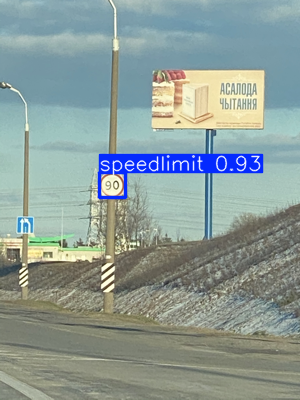

In [ ]:
# Step 7: Make predictions on sample images
sample_image = list((base_folder/"images/val").glob("*.png"))[0]
results = model.predict(str(sample_image))
results[0].show()